In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel, OptLoss

import math
import matplotlib.pyplot as plt
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

device = torch.device("cuda", 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from model import GaussianMixtureHumpModel

In [4]:
y_sampler = GaussianMixtureHumpModel(device, psi_init=torch.Tensor([0,0]))#, x_range=((-10, -10), (10, 10)))

In [5]:
step = 3
current_psi = torch.Tensor([0,0])
average_size=3000
psi_size=5000

In [6]:
#psi_range = (current_psi - step, current_psi + step)        
step = 3
psi_range = (current_psi - step , current_psi + step)

psi_grid = dist.Uniform(*psi_range).sample([psi_size]).to(device)
#x = y_sampler.x_dist.sample([average_size * psi_size, 1]).to(device)
#         psi_range = torch.tensor(lhs(len(current_psi), psi_size)).float().to(device)
#         scale = 1 if plot_in else scale_step
#         psi_grid = scale * train_step * (psi_range * 2 - 1) + current_psi.view(1, -1)        
x = y_sampler.sample_x(average_size * psi_size).to(device)

psi = psi_grid.repeat(1, average_size).view(-1, len(psi_range[0]))
psi.requires_grad = False
y_sampler.make_condition_sample({"mu": psi, "x": x})


data_gen = y_sampler.condition_sample(1)
loss = y_sampler.loss(data_gen).view(-1, average_size).mean(dim=1)

In [8]:
def grammy(y):
    return torch.sin(10 * math.pi * y) / (2 * y) + (y - 1) ** 4

def adijman(y):
    return torch.cos(y[:, 0]) * torch.sin(y[:, 1]) - y[:,0] /  (y[:,1] ** 2 + 1)

def three_hump(y):
    return 2 * y[:, 0] ** 2 - 1.05 * y[:, 0] ** 4 + y[:, 0] ** 6 / 6 + y[:,0] * y[:,1] + y[:, 1] ** 2

In [68]:
# splace = torch.linspace(-1, 3.5, 1000)
# plt.plot(splace.numpy(), grammy(splace).numpy())

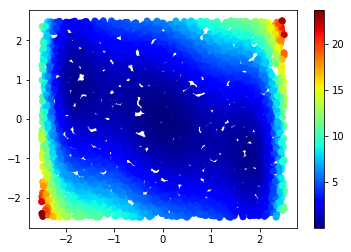

In [75]:
y = dist.Uniform(-2.5,2.5).sample([5000, 2])
plt.scatter(y[:,0], y[:,1], c=three_hump(y), cmap=my_cmap)
plt.colorbar()

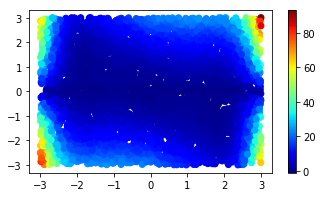

In [7]:
plt.figure(figsize=(12,3))
#psi_norm = 1 / 30 * psi_grid.norm(dim=1).detach().cpu()
plt.subplot(1,2,1)
plt.scatter(psi_grid[:,0].detach().cpu(),
            psi_grid[:,1].detach().cpu(),
            c=data_gen[:,0].view(-1, average_size).mean(dim=1).detach().cpu(), cmap=my_cmap, )
plt.colorbar()
# plt.subplot(1,2,2)
# plt.scatter(psi_grid[:,0].detach().cpu(),
#             psi_grid[:,1].detach().cpu(),
#             c=data_gen[:,1].view(-1, average_size).mean(dim=1).detach().cpu(), cmap=my_cmap)
# plt.colorbar()

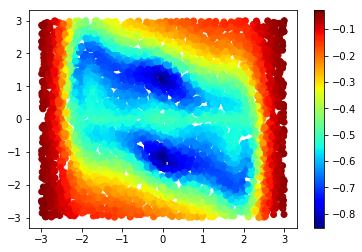

In [8]:
psi_norm = 1 / 30 * psi_grid.norm(dim=1).detach().cpu()
plt.scatter(psi_grid[:,0].detach().cpu(),
            psi_grid[:,1].detach().cpu(),
            c=loss.detach().cpu(), cmap=my_cmap)
plt.colorbar()

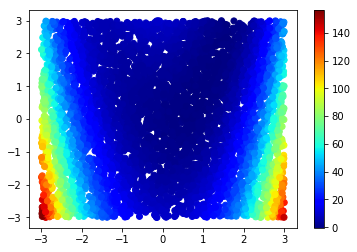

In [62]:
plt.scatter(psi_grid[:,0].detach().cpu(), psi_grid[:,1].detach().cpu(), c=loss.detach().cpu(), cmap=my_cmap)
plt.colorbar()

In [188]:
def mixtue_model(weights, K=2):
    # Global variables.
    #weights = pyro.sample('weights', dist.Dirichlet(torch.Tensor([0.3, 0.7])))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 3.))
        scales = pyro.sample('scale', dist.LogNormal(0., 0.5))

    with pyro.plate('data', 10000):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        return pyro.sample('obs', dist.Normal(locs[assignment], scales[assignment]))

In [190]:
model(torch.Tensor([0.9, 1]))

tensor([-1.0648,  2.7542, -2.2034,  ..., -0.3151, -2.8213, -2.8942])

tensor([0.8783, 0.1217])
tensor(8747)


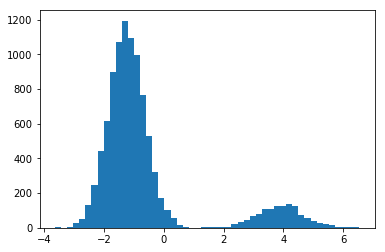

In [187]:
plt.hist(model(),bins=50);

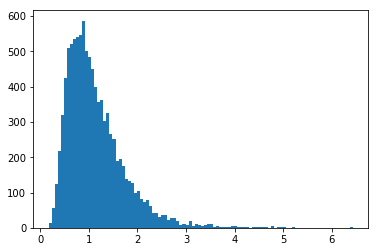

In [102]:
plt.hist(dist.LogNormal(0., 0.5).sample([10000]),bins=100);